## Установка пакетов

In [ ]:
!pip uninstall -y codeplag
!pip install ../

## Импортирование установленных пакетов

In [1]:
import codeplag
import webparsers

# Быстрый поиск схожих работ без подробностей

In [2]:
from codeplag.algorithms.tokenbased import value_jakkar_coef
from codeplag.utils import get_files_path_from_directory
from codeplag.pyplag.utils import get_ast_from_filename, get_features_from_ast

In [3]:
py_files = get_files_path_from_directory('../src/codeplag/', extension='.py')

In [4]:
import pandas as pd
import numpy as np
from codeplag.pyplag.utils import get_ast_from_filename, get_features_from_ast

chacked_files = 15
mapped_files = list(map(lambda x: x.split('/')[-1], py_files[:chacked_files]))
count_files = len(py_files)
df = pd.DataFrame(index=mapped_files, columns=mapped_files, data=np.zeros((chacked_files, chacked_files)))
i = 0
for file1 in py_files[:chacked_files]:
    tree1 = get_ast_from_filename(file1)
    features1 = get_features_from_ast(tree1, file1)
    j = 0
    for file2 in py_files[:chacked_files]:
        if i == j:
            df.iloc[i, j] = 1.0
            break

        tree2 = get_ast_from_filename(file2)
        features2 = get_features_from_ast(tree2, file2)
        result = value_jakkar_coef(features1.tokens, features2.tokens) 
        df.iloc[i, j] = result
        df.iloc[j, i] = result
        j += 1

    i += 1

**Чем ближе к нулю значение метрики, тем меньше соответсвие двух исходных кодов программ, чем ближе к единице, тем выше схожесть.**

Можно обозначить пороговое значение, при котором будет срабатывать предупреждение, что работы похожи по содрежанию, к примеру и запускать более показательные алгоритмы, которые смогут показать схожие части двух программ.

<AxesSubplot:>

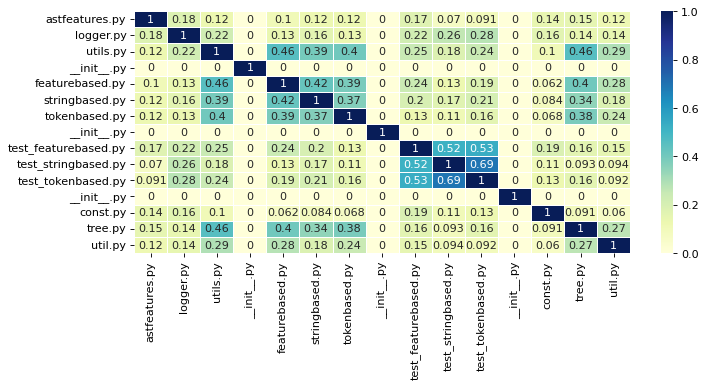

In [5]:
from matplotlib.pyplot import figure
import seaborn as sns

figure(figsize=(10, 4), dpi=80)
sns.heatmap(df, annot=True, linewidths=.6, cmap="YlGnBu")

# Быстрый поиск схожих работ без подробностей на основе составной метрики

Данная метрика состоит из коэффициента Жаккара и трёх метрик счёткиков. Каждому полученному значению применённых алгоритмов ставится свой вес.

In [6]:
from codeplag.utils import run_compare

import pandas as pd
import numpy as np
from codeplag.pyplag.utils import get_ast_from_filename, get_features_from_ast

weights = np.array([1, 0.4, 0.4, 0.4], dtype=np.float32)
chacked_files = 15
mapped_files = list(map(lambda x: x.split('/')[-1], py_files[:chacked_files]))
count_files = len(py_files)
df = pd.DataFrame(index=mapped_files, columns=mapped_files, data=np.zeros((chacked_files, chacked_files)))
i = 0
for file1 in py_files[:chacked_files]:
    tree1 = get_ast_from_filename(file1)
    features1 = get_features_from_ast(tree1, file1)
    j = 0
    for file2 in py_files[:chacked_files]:
        if i == j:
            df.iloc[i, j] = 1.0
            break

        tree2 = get_ast_from_filename(file2)
        features2 = get_features_from_ast(tree2, file2)
        result = np.sum(run_compare(features1, features2) * weights) / weights.sum()
        df.iloc[i, j] = result
        df.iloc[j, i] = result
        j += 1

    i += 1

<AxesSubplot:>

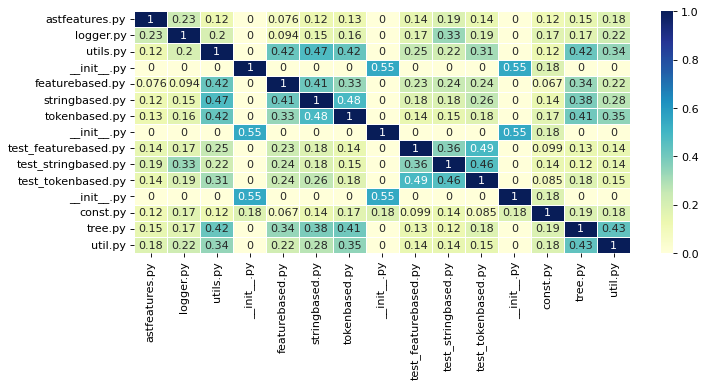

In [7]:
from matplotlib.pyplot import figure
import seaborn as sns

figure(figsize=(10, 4), dpi=80)
sns.heatmap(df, annot=True, linewidths=.6, cmap="YlGnBu")

# Поиск схожих частей верхних уровней, построенный на собственном алгоритме (работает долго, точность поиска не гаранитруется)

In [8]:
from codeplag.algorithms.featurebased import struct_compare

In [9]:
filename1 = '../Notebooks/samples/tokenbased_old.py'
filename2 = '../src/codeplag/algorithms/tokenbased.py'
tree1 = get_ast_from_filename(filename1)
tree2 = get_ast_from_filename(filename2)
features1 = get_features_from_ast(tree1, filename1)
features2 = get_features_from_ast(tree2, filename2)

<AxesSubplot:>

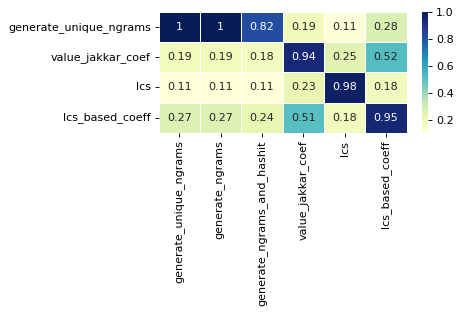

In [10]:
compliance_matrix = np.zeros((len(features1.head_nodes),
                              len(features2.head_nodes), 2),
                             dtype=np.int64)
struct_res = struct_compare(features1.structure, features2.structure, compliance_matrix)
data = np.zeros((compliance_matrix.shape[0],
                 compliance_matrix.shape[1]),
                dtype=np.float32)
for row in range(compliance_matrix.shape[0]):
    for col in range(compliance_matrix.shape[1]):
        data[row][col] = (compliance_matrix[row][col][0] / compliance_matrix[row][col][1])

df = pd.DataFrame(data=data, index=features1.head_nodes, columns=features2.head_nodes)
figure(figsize=(5, 2), dpi=80)
sns.heatmap(df, annot=True, linewidths=.6, cmap="YlGnBu")

# Выделение схожих фрагментов двух программ с помощью  Greedy String Tiling алгоритма

In [11]:
from codeplag.pyplag.utils import get_ast_from_filename, get_features_from_ast

filename1 = '../Notebooks/samples/tokenbased_old.py'
filename2 = '../src/codeplag/algorithms/tokenbased.py'
tree1 = get_ast_from_filename(filename1)
tree2 = get_ast_from_filename(filename2)
features1 = get_features_from_ast(tree1, filename1)
features2 = get_features_from_ast(tree2, filename2)

In [12]:
from codeplag.algorithms.stringbased import gst

answer = gst(features1.tokens, features2.tokens, 7)

In [13]:
from codeplag.utils import print_suspect_parts

with open(filename1, 'r') as f:
    text1 = f.read()

with open(filename2, 'r') as f:
    text2 = f.read()

print_suspect_parts(text1, answer[0], features1.tokens_pos)

from numba import njit


def generate_unique_ngrams(tokens, n=3):
    '''
        The function returns a set of N-grams.
        @param tokens - list of tokens
        @param n - count of elements in sequences
    '''
    return {tuple(tokens[i:i + n]) for i in range(len(tokens) - n + 1)}


def value_jakkar_coef(tokens_first, tokens_second):
    '''
        The function returns the value of the Jakkar coefficient
        @param tokens_first - list of tokens of the first program
        @param tokens_second - list of tokens of the second program
    '''
    ngrams_first = generate_unique_ngrams(tokens_first, 3)
    ngrams_second = generate_unique_ngrams(tokens_second, 3)

    intersection = len(ngrams_first.intersection(ngrams_second))
    union = len(ngrams_first | ngrams_second)

    if union == 0:
        return 0.0

    return intersection / union


@njit(fastmath=True)
def lcs(X, Y):
    '''
        The function returns the length of the longest common subsequence
        of two se

In [14]:
print_suspect_parts(text2, answer[1], features2.tokens_pos)

import binascii


def generate_unique_ngrams(tokens, n=3):
    """The function returns a set of N-grams
    and may use to generate shingles.

    @param tokens - list of tokens
    @param n - count of elements in sequences
    """

    return {tuple(tokens[i:i + n]) for i in range(len(tokens) - n + 1)}


def generate_ngrams(tokens, n=3):
    """The function returns a list of N-grams
    and may use to generate shingles.

    @param tokens - list of tokens
    @param n - count of elements in sequences
    """

    return [tuple(tokens[i:i + n]) for i in range(len(tokens) - n + 1)]


def generate_ngrams_and_hashit(tokens, n=3):
    """The function generates and hashes ngrams
    which gets from the tokens sequence.

    @param tokens - list of tokens
    @param n - count of elements in sequences
    """

    return [binascii.crc32(bytearray(tokens[i:i + n]))
            for i in range(len(tokens) - n + 1)]


def value_jakkar_coef(tokens_first, tokens_second, ngrams_length=3):
    '''
  

**NB.** Строки документации (""" """, не путать с #) в Python считаются константным значением поэтому GST определяет, что функции, отличающиеся только наличием документации отличаются и совпадают только в месте самого исполнения кода. Нужно учитывать что обычно такие строки не будут писаться просто так, либо исключать их из программы.

# Взаимодействие с удалёнными репозиториями

In [15]:
from webparsers.github_parser import GitHubParser
from decouple import Config, RepositoryEnv

env_config = Config(RepositoryEnv('../.env'))
gh = GitHubParser(access_token=env_config.get('ACCESS_TOKEN'))

**Ключ - название репозитория, значение - ссылка на репозиторий**

In [16]:
import re

gh.get_list_of_repos('OSLL', reg_exp=r"[abc]df\w*21")

{'adfmp1h21-alias': 'https://github.com/OSLL/adfmp1h21-alias',
 'adfmp1h21-birds': 'https://github.com/OSLL/adfmp1h21-birds',
 'adfmp1h21-crocodile': 'https://github.com/OSLL/adfmp1h21-crocodile',
 'adfmp1h21-iq': 'https://github.com/OSLL/adfmp1h21-iq',
 'adfmp1h21-mushrooms': 'https://github.com/OSLL/adfmp1h21-mushrooms',
 'adfmp1h21-verbal-counting': 'https://github.com/OSLL/adfmp1h21-verbal-counting'}

In [17]:
gh.get_name_default_branch('OSLL', 'code-plagiarism')

'main'

**Ключ - название ветки, значение - sha commit'а**

In [18]:
gh.get_list_repo_branches('OSLL', 'code-plagiarism')

{'iss65': 'b42b29152ef1242bbfa1c461db305d09dd0b6047',
 'iss67': '138c2e60ac56d31be604903922be669cd8a73b94',
 'main': '9f4a67dbf314e46224e80367bab654f3b6f9735b'}

In [19]:
print(gh.get_file_from_url('https://github.com/OSLL/code-plagiarism/blob/main/LICENSE')[0])

License agreement for codeplag versions 0.0.1 and later

MIT License

Copyright (c) 2021 Codeplag Development Team 

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN A

In [20]:
files1 = list(gh.get_files_generator_from_repo_url('https://github.com/OSLL/code-plagiarism'))

In [21]:
print(files1[10][0])

class ASTFeatures:
    def __init__(self, filepath=''):
        self.filepath = filepath

        self.count_of_nodes = 0
        self.head_nodes = []
        self.operators = {}
        self.keywords = {}
        self.literals = {}

        # unique nodes
        self.unodes = {}
        self.from_num = {}
        self.count_unodes = 0

        self.structure = []
        self.tokens = []
        self.tokens_pos = []



In [22]:
files2 = list(gh.get_files_generator_from_dir_url('https://github.com/OSLL/code-plagiarism/tree/main/src/webparsers'))
print(files2[0][1])
print(files2[1][1])

https://github.com/OSLL/code-plagiarism/tree/main/src/webparsers/__init__.py
https://github.com/OSLL/code-plagiarism/tree/main/src/webparsers/github_parser.py
